In [2]:
import warnings
warnings.filterwarnings("ignore")
from evaluation.mol_structure import list_of_smiles_to_nx_graphs,list_of_nx_graphs_to_smiles
from evaluation.mol_structure import draw_one_mol, draw_graphs
from evaluation.new_structural_metric import symmetric_graph_set_distance,atom,cycle,neighborhood
from evaluate import evaluate
#import utils.graph_generators as gen
import torch
import networkx as nx
import os 
import sys
import json
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
import rdkit
import numpy as np
from evaluation.utils import get_data,  get_mock_data,remove_empty_graphs_and_targets,\
    get_generated_data,preprocess


In [5]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']#'common_substructures']
metrics_type=['nn','structural']#'molecular']
#leave it blank to compute all the structural structures 
ggenerators=['swingnn']

device=torch.device('cpu')
metrics={}
for generator in ['train2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=train2_graphs , train2_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

ames_25
Now computing classifier based metrics
Now computing structural based metrics
{'activations_time': 0.09702658653259277, 'fid': 10.111177292571057, 'fid_time': 0.12618660926818848, 'kid': 0.0035070777, 'kid_time': 0.17718076705932617, 'precision': 0.9677926158680282, 'recall': 0.98114689709348, 'f1_pr': 0.9744340046768142, 'precision_time': 0.5745255947113037, 'recall_time': 0.5745255947113037, 'f1_pr_time': 0.5745255947113037, 'density': 0.9743912018853103, 'coverage': 0.9756480754124116, 'f1_dc': 0.9750292336019268, 'density_time': 0.3673076629638672, 'coverage_time': 0.3673076629638672, 'f1_dc_time': 0.3673076629638672, 'mmd_rbf': 0.0019698739051818848, 'mmd_rbf_time': 0.7162625789642334, 'mmd_linear': 0.15714261, 'mmd_linear_time': 0.09714245796203613, 'wl_mmd': 0.0015710919088766694, 'wl_mmd_time': 1.177459955215454, 'nspdk_mmd': 0.001448980268111244, 'nspdk_mmd_time': 7.530579090118408, 'degree_mmd': 0.00026359444890333705, 'degree_mmd_time': 15.093933, 'cluster_mmd': 7.42

In [6]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']#'common_substructures']
metrics_type=['nn','structural']#'molecular']
#leave it blank to compute all the structural structures 
ggenerators=['swingnn']

device=torch.device('cpu')
metrics={}
for generator in ['train1/2+train2/2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            half=len(train1_graphs)//2
            half2=len(train2_graphs)//2
            train3_graphs,train3_targets=train1_graphs[:half]+train2_graphs[:half], train1_targets[:half]+train2_targets[:half]
            generated_graphs, generated_targets=train3_graphs , train3_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

ames_25
Now computing classifier based metrics
Now computing structural based metrics
{'activations_time': 0.10300421714782715, 'fid': 0.22692464756022446, 'fid_time': 0.1081082820892334, 'kid': -0.08133352, 'kid_time': 0.16507530212402344, 'precision': 0.9827044025157232, 'recall': 0.992930086410055, 'f1_pr': 0.9878007811790271, 'precision_time': 0.25174641609191895, 'recall_time': 0.25174641609191895, 'f1_pr_time': 0.25174641609191895, 'density': 1.07625786163522, 'coverage': 0.992930086410055, 'f1_dc': 1.0329261537410812, 'density_time': 0.2215251922607422, 'coverage_time': 0.2215251922607422, 'f1_dc_time': 0.2215251922607422, 'mmd_rbf': 0.0007851077825762331, 'mmd_rbf_time': 0.3714780807495117, 'mmd_linear': 0.039750893, 'mmd_linear_time': 0.10309529304504395, 'wl_mmd': 0.0015717094764509134, 'wl_mmd_time': 1.167114019393921, 'nspdk_mmd': 0.0006937447505587224, 'nspdk_mmd_time': 7.316859006881714, 'degree_mmd': 5.5570335422139294e-05, 'degree_mmd_time': 14.993548, 'cluster_mmd': 9.

In [4]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']#'common_substructures']
metrics_type=['nn','structural']#'molecular']
#leave it blank to compute all the structural structures 
ggenerators=['swingnn']

device=torch.device('cpu')
metrics={}
for generator in ['swingnn']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=get_generated_data(dataset_name+split, generator_name=generator)
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

ames_25
Now computing the auc_roc based  metric
0.8464607567551096 0.8834672166739036 0.700815488569448 0.8311946279071539
{'AUC_ROC_based_metric_with_nspdk': 0, 'AUC_ROC_based_metric_with_nspdk_time': 54.95044302940369, 'dataset': 'ames_25', 'generator_name': 'swingnn'}
ames_33
Now computing the auc_roc based  metric
0.8588625819868821 0.8983762597984324 0.7117556429066587 0.8313469844824828
{'AUC_ROC_based_metric_with_nspdk': 0, 'AUC_ROC_based_metric_with_nspdk_time': 64.6409158706665, 'dataset': 'ames_33', 'generator_name': 'swingnn'}
ames_40
Now computing the auc_roc based  metric
0.8790783950758354 0.9045038508124413 0.7399977908296577 0.8670593657395769
{'AUC_ROC_based_metric_with_nspdk': 0, 'AUC_ROC_based_metric_with_nspdk_time': 94.06180214881897, 'dataset': 'ames_40', 'generator_name': 'swingnn'}
ames_50
Now computing the auc_roc based  metric
0.8856954315880887 0.9113656100738168 0.7732753235672768 0.8763264544339572
{'AUC_ROC_based_metric_with_nspdk': 0, 'AUC_ROC_based_metri

# Data collection

## Hide

In [3]:
#disable  
from rdkit import RDLogger 
RDLogger.EnableLog('rdApp.*')
#RDLogger.DisableLog('rdApp.*')        
name='ames'                                                                                                                                                                                                                                                                                                                                                                                                                                                               
path='data/smiles/{}/train1_smiles.txt'.format(name)
#rom data.smiles.carcinogens import test_smiles
reference_smiles_list = []
with open(path) as my_file:
    for line in my_file:
        reference_smiles_list.append(line)
reference_nx_graphs=list_of_smiles_to_nx_graphs(reference_smiles_list)
"""
print(reference_smiles_list[0])
mol = Chem.MolFromSmiles(reference_smiles_list[0])
Chem.Kekulize(mol)
Chem.RemoveStereochemistry(mol)
Chem.rdmolops.AddHs(mol)
print(mol_to_smiles([mol])[0])
print(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0])
rdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(reference_smiles_list[0]))
rdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]))

#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )

#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )
"""

'\nprint(reference_smiles_list[0])\nmol = Chem.MolFromSmiles(reference_smiles_list[0])\nChem.Kekulize(mol)\nChem.RemoveStereochemistry(mol)\nChem.rdmolops.AddHs(mol)\nprint(mol_to_smiles([mol])[0])\nprint(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0])\nrdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(reference_smiles_list[0]))\nrdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]))\n\n#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )\n\n#rdkit.Chem.Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(mol_to_smiles([nx_to_mol(reference_nx_graphs[0])])[0]),   Chem.MolFromSmiles(reference_smiles_list[0])  ]  )\n'

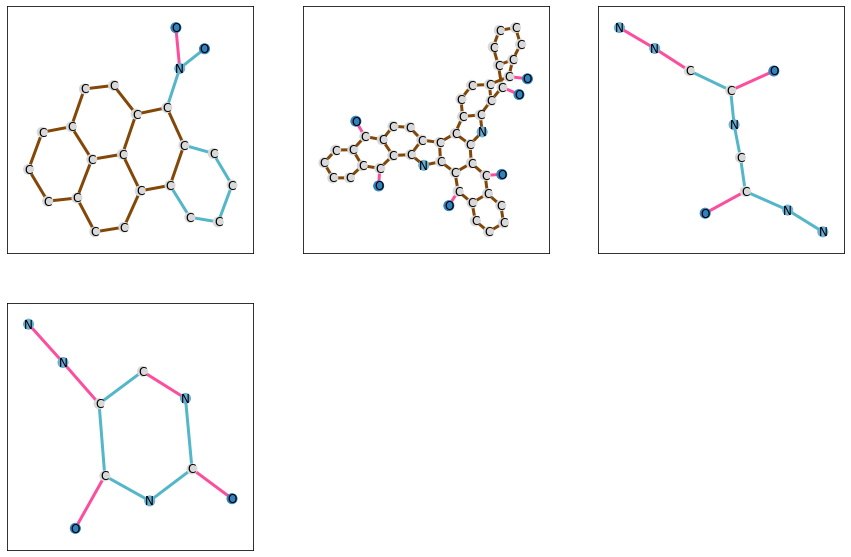

In [66]:
list_of_G=reference_nx_graphs[:4]
#for n , d in (G.nodes().items() ):
    #print(str(d['label'][0]))

draw_graphs(list_of_G)

[N-]=[N+]=CC(=O)NCC(=O)NN



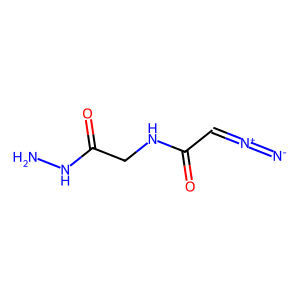

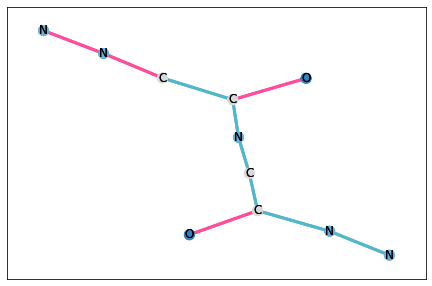

In [68]:
draw_one_mol(reference_nx_graphs[2])
print(reference_smiles_list[2])
draw_one_mol(reference_nx_graphs[2])

rdkit.Chem.Draw.MolToImage(mol = Chem.MolFromSmiles(reference_smiles_list[2]))


In [69]:
reference_nx_graphs[0].nodes(data=True)

NodeDataView({0: {'label': 8, 'attr': [7, 0, 1, 5, 0, 0, 1, 0, 0], 'label_name': 'O'}, 1: {'label': 7, 'attr': [6, 0, 3, 6, 0, 0, 1, 0, 0], 'label_name': 'N'}, 2: {'label': 8, 'attr': [7, 0, 1, 4, 0, 0, 1, 0, 0], 'label_name': 'O'}, 3: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 4: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 5: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 6: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 7: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 8: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 9: {'label': 6, 'attr': [5, 0, 3, 5, 0, 0, 1, 1, 1], 'label_name': 'C'}, 10: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 11: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 12: {'label': 6, 'attr': [5, 0, 3, 5, 1, 0, 1, 1, 1], 'label_name': 'C'}, 13: {'label': 6, 'attr': [5, 0, 3,

In [70]:
reference_nx_graphs[0].edges(data=True)

EdgeDataView([(0, 1, {'label': 2, 'attr': [1, 0, 1], 'edge_label': 'DOUBLE'}), (1, 2, {'label': 1, 'attr': [0, 0, 1], 'edge_label': 'SINGLE'}), (1, 3, {'label': 1, 'attr': [0, 0, 1], 'edge_label': 'SINGLE'}), (3, 4, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (3, 16, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (4, 5, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (4, 22, {'label': 1, 'attr': [0, 0, 0], 'edge_label': 'SINGLE'}), (5, 6, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (5, 19, {'label': 1, 'attr': [0, 0, 0], 'edge_label': 'SINGLE'}), (6, 7, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (6, 17, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (7, 8, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (8, 9, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (9, 10, {'label': 1, 'attr': [3, 0, 1], 'edge_label': 'AROMATIC'}), (9, 18, {'label': 1, 'attr': [3, 0, 1], 'edge_label':

## Show


In [2]:
current_smiles_datasets=['ames', 'bbb_martins', 'cyp1a2_veith', 'cyp2c19_veith','herg_karim','lipophilicity_astrazeneca']
splits=['_25','_33','_40','_50']
device=torch.device('cpu')
structural_statistic=['WL', 'nspdk','degree','cluster', 'spectral']#'common_substructures']
metrics_type=['nn', 'structural']#'molecular']
#leave it blank to compute all the structural structures 
generators=['hiervae','wgan','stgg','moflow','gdss','jtnn','swingnn']



In [3]:
device=torch.device('cpu')
metrics={}
for generator in ['train1']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=train1_graphs,train1_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

ames_25
Now computing classifier based metrics
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Now computing structural based metrics
{'activations_time': 0.09497904777526855, 'fid': -2.05708658995718e-08, 'fid_time': 0.10605001449584961, 'kid': -1.0951546, 'kid_time': 4.503940105438232, 'precision': 1.0, 'recall': 1.0, 'f1_pr': 1.00001, 'precision_time': 0.5347938537597656, 'recall_time': 0.5347938537597656, 'f1_pr_time': 0.5347938537597656, 'density': 1.2001571091908878, 'coverage': 1.0, 'f1_dc': 1.0909840901883978, 'density_time': 0.31894588470458984, 'coverage_time': 0.31894588470458984, 'f1_dc_time': 0.31894588470458984, 'mmd_rbf': 0, 'mmd_rbf_time': 0.5747997760772705, 'mmd_linear': 0.0, 'mmd_linear_time': 0.09510588645935059, 'wl_mmd': 0.0015710919088766694, 'wl_mmd_time': 1.1218819618225098, '

In [20]:
device=torch.device('cpu')
metrics={}
for generator in ['train2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=train2_graphs,train2_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

ames_25
Now computing classifier based metrics
Now computing structural based metrics
{'activations_time': 0.10030484199523926, 'fid': 4.865800534791404, 'fid_time': 0.10283994674682617, 'kid': 0.19350207, 'kid_time': 0.1501750946044922, 'precision': 0.9685781618224666, 'recall': 0.9732914375490966, 'f1_pr': 0.9709390797498794, 'precision_time': 0.2710459232330322, 'recall_time': 0.2710459232330322, 'f1_pr_time': 0.2710459232330322, 'density': 0.9538098978790259, 'coverage': 0.9536527886881383, 'f1_dc': 0.9537413368134584, 'density_time': 0.20402002334594727, 'coverage_time': 0.20402002334594727, 'f1_dc_time': 0.20402002334594727, 'mmd_rbf': 0.001806885004043579, 'mmd_rbf_time': 0.40337681770324707, 'mmd_linear': 0.103768684, 'mmd_linear_time': 0.10039353370666504, 'wl_mmd': 0.0015710919088766694, 'wl_mmd_time': 1.1708450317382812, 'nspdk_mmd': 0.0014388091537828052, 'nspdk_mmd_time': 7.240663766860962, 'degree_mmd': 0.00026359444890333705, 'degree_mmd_time': 13.983711, 'cluster_mmd': 

In [21]:
device=torch.device('cpu')
metrics={}
for generator in ['train1/2+train2/2']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            half=len(train1_graphs)//2
            half2=len(train2_graphs)//2
            train3_graphs,train3_targets=train1_graphs[:half]+train2_graphs[:half], train1_targets[:half]+train2_targets[:half]
            generated_graphs, generated_targets=train3_graphs,train3_targets
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

ames_25
Now computing classifier based metrics
Now computing structural based metrics
{'activations_time': 0.11600613594055176, 'fid': 0.26529592569566773, 'fid_time': 0.11844015121459961, 'kid': -0.13259184, 'kid_time': 0.17257905006408691, 'precision': 0.985062893081761, 'recall': 0.9890023566378633, 'f1_pr': 0.9870386940839978, 'precision_time': 0.2710721492767334, 'recall_time': 0.2710721492767334, 'f1_pr_time': 0.2710721492767334, 'density': 1.0874213836477986, 'coverage': 0.9968578161822467, 'f1_dc': 1.0401820897435567, 'density_time': 0.2116091251373291, 'coverage_time': 0.2116091251373291, 'f1_dc_time': 0.2116091251373291, 'mmd_rbf': 0.0007812039693817496, 'mmd_rbf_time': 0.4290952682495117, 'mmd_linear': 0.040126182, 'mmd_linear_time': 0.11609411239624023, 'wl_mmd': 0.0015717094764509134, 'wl_mmd_time': 1.1388211250305176, 'nspdk_mmd': 0.0006969923526666255, 'nspdk_mmd_time': 7.189409971237183, 'degree_mmd': 5.5570335422139294e-05, 'degree_mmd_time': 14.900045, 'cluster_mmd': 

KeyboardInterrupt: 

In [3]:
device=torch.device('cpu')
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=get_generated_data(dataset_name+split, generator_name=generator)
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)


ames_25
Now computing classifier based metrics



Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Now computing structural based metrics
Now computing  molecular specific metrics
Now computing the auc_roc based  metric
0.8277675571908495 0.872026190095299 0.5720598989875905 0.8186699651865226
{'activations_time': 0.3725905418395996, 'fid': 121.43981799207279, 'fid_time': 0.3765876293182373, 'kid': 9.407125, 'kid_time': 9.418147563934326, 'precision': 0.989516129032258, 'recall': 0.10761979575805185, 'f1_pr': 0.1941428611167597, 'precision_time': 0.6866919994354248, 'recall_time': 0.6866919994354248, 'f1_pr_time': 0.6866919994354248, 'density': 0.6798387096774194, 'coverage': 0.07619795758051846, 'f1_dc': 0.13705290587852567, 'density_time': 0.5635957717895508, 'coverage_time': 0.5635957717895508, 'f1_dc_time': 0.5635957717895508, 'mmd_rbf': 0.6937805712223053, 'mmd_rbf_time': 0.9992003440856934, 'mmd_linear': 91.91981, 'mmd_linear_time': 0.3725905418395996, 'nspdk_mmd': 0.18164687312546535, 'nspdk_mmd_time': 12.985737800598145, 'wl_mmd': 0.394148303905733, 'wl_mmd_time': 1.48797965

In [6]:
device=torch.device('cpu')
metrics={}
for generator in generators:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=get_generated_data(dataset_name+split, generator_name=generator)
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)

cyp2c19_veith_25


In [ ]:
device=torch.device('cpu')
metrics={}
for generator in ['jtnn']:
    for dataset_name in current_smiles_datasets:
        for split in splits:
            print(dataset_name+split)
            train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name+split, return_smiles=False)
            generated_graphs, generated_targets=get_generated_data(dataset_name+split, generator_name=generator)
            splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
            metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
            metrics['dataset']=dataset_name+split
            metrics['generator_name']=generator
            print(metrics)


ames_25
Now computing classifier based metrics
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
Now computing structural based metrics
Now computing  molecular specific metrics
Now computing the auc_roc based  metric
0.8277675571908495 0.872026190095299 0.4387755102040816 0.830048144677804
{'activations_time': 0.35055065155029297, 'fid': 88.31845989434339, 'fid_time': 0.3565495014190674, 'kid': 5.8072014, 'kid_time': 0.40155506134033203, 'precision': 0.9661590524534687, 'recall': 0.29615082482325217, 'f1_pr': 0.4533544339624197, 'precision_time': 0.5045478343963623, 'recall_time': 0.5045478343963623, 'f1_pr_time': 0.5045478343963623, 'density': 0.4780033840947547, 'coverage': 0.06912804399057344, 'f1_dc': 0.12080352414787834, 'density_time': 0.4605555534362793, 'coverage_time': 0.4605555534362793, 'f1_dc_time': 0.4605555534362793, 'mmd_rbf': 0.5318998098373413, 'mmd_rbf_time': 0.7165534496307373, 'mmd_linear': 66.03929, 'mmd_linear_time': 0.351550102

## Dev

## Vectorize


In [ ]:
from eden.ml.ml import serial_vectorize as vectorize
from eden.graph import Vectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score

estimator =ExtraTreesClassifier(n_estimators=300, n_jobs=-1,random_state=0)
generator='stgg'
dataset_name='cyp1a2_veith'
metrics_type=['auc_roc']
train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name, return_smiles=False)
generated_graphs, generated_targets=get_generated_data(dataset_name,generator_name=generator)
train_graphs, train_targets=train1_graphs +  train2_graphs , list(train1_targets)+list(train2_targets)
train1_plus_generated_targets=list(train1_targets)+list(generated_targets)   
   
vectorizer = Vectorizer(
            r=2, d=4,
            normalization=False,
            inner_normalization=False,
            discrete=True,
            nbits=10)

def serialize(train_graphs,test_graphs,train1_graphs,generated_graphs):
        X_train=vectorize(train_graphs,vectorizer=vectorizer).toarray()
        X_test=vectorize(test_graphs,vectorizer=vectorizer).toarray()
        X_train1=vectorize(train1_graphs,vectorizer=vectorizer).toarray()
        X_generated=vectorize(generated_graphs,vectorizer=vectorizer).toarray()
        X_train1_plus_generated=np.vstack((X_train1,X_generated))
        return X_train,X_test,X_train1,X_generated,X_train1_plus_generated
X_train,X_test,X_train1,X_generated,X_train1_plus_generated=serialize(train_graphs,test_graphs,train1_graphs,generated_graphs)

def predict(test_embedding):
        preds= estimator.predict_proba(test_embedding)[:,1]
        return preds
def compute_auc(X_train, train_targets,X_test, test_targets):
    estimator.fit( X_train,train_targets)
    preds=predict(X_test )
    auc=roc_auc_score(test_targets, preds)
    return auc

auc_1= compute_auc(X_train1, train1_targets, X_test, test_targets)
auc_2=compute_auc(X_train, train_targets, X_test, test_targets)
auc_3=compute_auc(X_generated, generated_targets, X_test, test_targets)
auc_4=compute_auc( X_train1_plus_generated,train1_plus_generated_targets, X_test, test_targets)
print(auc_1, auc_2,auc_3,auc_4 )


In [ ]:
metrics={}

metrics_type=['auc_roc']
for generator in ['stgg','gdss','hiervae','moflow','wgan']:
    for dataset_name in ['cyp1a2_veith']:
        train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets  =get_data(dataset_name, return_smiles=False)
        generated_graphs, generated_targets=get_generated_data(dataset_name,generator_name=generator)
        splits_for_auc_roc=[train1_graphs , train1_targets,train2_graphs , train2_targets, test_graphs, test_targets, generated_graphs, generated_targets]
        metrics=evaluate(train1_graphs, generated_graphs, device,  metrics_type, structural_statistic,*splits_for_auc_roc)
        metrics['dataset']=dataset_name
        metrics['generator_name']=generator
        print(metrics)

Now computing the auc_roc based  metric
0.595007555474423 0.847280853210823 0.4850858611212527 0.56162909212608
Error when computing AUC_ROC with an nn classifier
{'AUC_ROC_based_metric_with_nspdk': 0, 'AUC_ROC_based_metric_with_nspdk_time': 192.33314204216003, 'dataset': 'cyp1a2_veith', 'generator_name': 'stgg'}
Now computing the auc_roc based  metric
0.9063466619001258 0.9225681133625412 0.5415437000527361 0.901334821609671
Error when computing AUC_ROC with an nn classifier
{'AUC_ROC_based_metric_with_nspdk': 0, 'AUC_ROC_based_metric_with_nspdk_time': 161.56497645378113, 'dataset': 'cyp1a2_veith', 'generator_name': 'gdss'}
Now computing the auc_roc based  metric
0.9085933379984584 0.9232190757981421 0.6721123762727679 0.9059112079631657
Error when computing AUC_ROC with an nn classifier
{'AUC_ROC_based_metric_with_nspdk': 0, 'AUC_ROC_based_metric_with_nspdk_time': 148.0914294719696, 'dataset': 'cyp1a2_veith', 'generator_name': 'hiervae'}
Now computing the auc_roc based  metric
0.8755

# New metric  (Step 1 and Step 2)

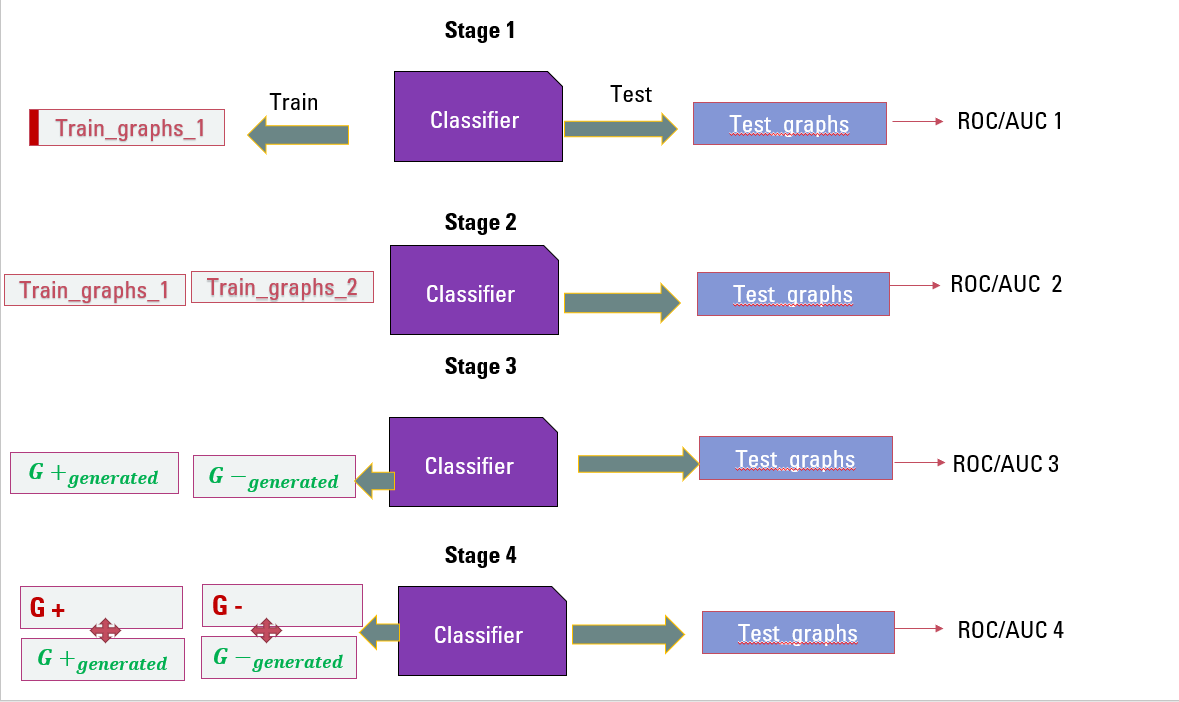

# NN classifier  with ogb AtomEncoder, BondEncoder

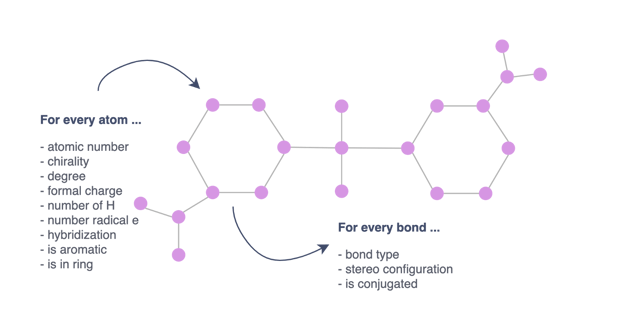